# Plot and Spikesort Backyard Brains Recordings

This notebook provides code to:

1. Import the wave file recorded with Spike Recorder
2. Plot the raw data
3. Determine a reasonable spike threshold
4. Detect spikes based on that threshold
5. Plot the raw waveforms & waveform features for detected spikes
6. Run a PCA on the extracted waveforms

*Note*: This code relies on several helper functions in `spikesorting_helperfunctions.py`. Please make sure this file is in the same folder as this notebook.

<hr>

## Setup

In [27]:
# Import packages we need 
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # configure high-resolution plotting
%run spikesorting_helperfunctions.py # import several helper functions for this analysis
print('Packages & Helper Functions Imported.')

Packages & Helper Functions Imported.


## Import wav file recorded with Spike Recorder

In [2]:
from scipy.io.wavfile import read
byb_file = read('my_recording.wav')
entire_recording = np.array(byb_file[1],dtype=float)

# Get the time domain
sampling_freq = 10000 # SpikeRecorder acquires data at 10 kHz
timestamps = np.arange(len(entire_recording))/sampling_freq

# For signal values [-30K,30K], conversion is 1 unit = 6.7 nV
# This will therefore convert our signals to mV
conversion_factor = 6.7e-3
entire_recording *= conversion_factor

## Plot the raw data

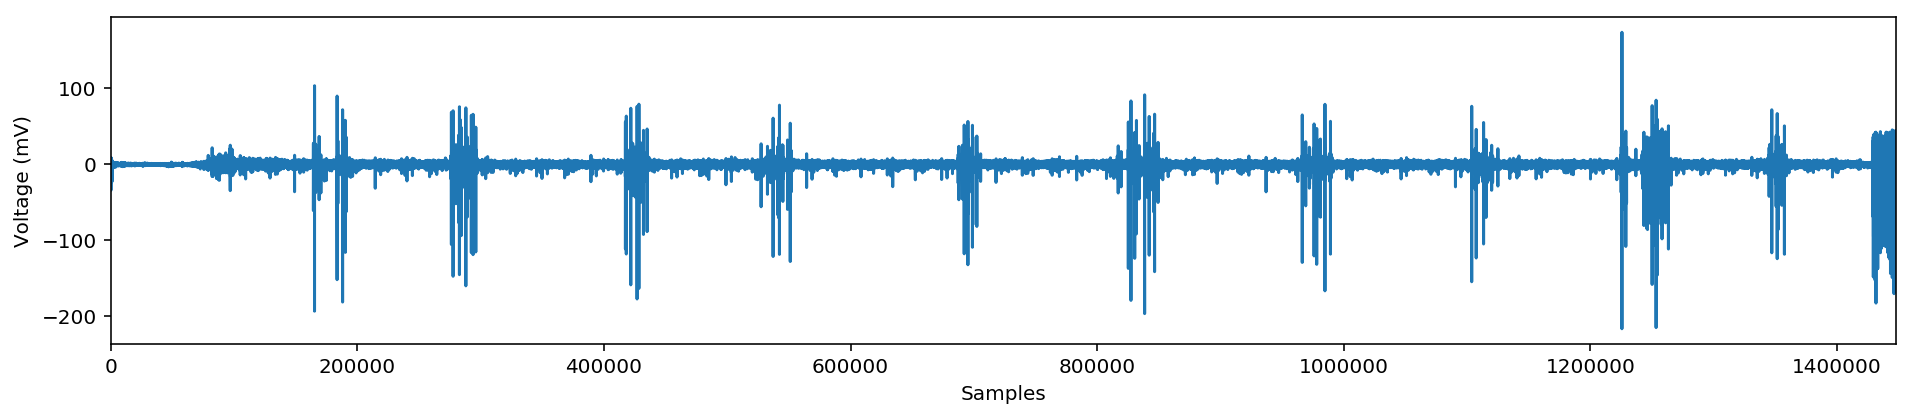

In [79]:
fig = plt.figure(figsize=(20,5))
plt.plot(entire_recording)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.xlim([0,len(entire_recording)])
plt.show()

## Subselect a length of data to work with

Chances are, your recording includes turning the recording on in the beginning, and possibly some junk at the end too. Below, you can determine the `signal` we'll actually sort by changing the values in the brackets after `entire_recording`. These values should be in terms of samples (like the plot above), *not* time.

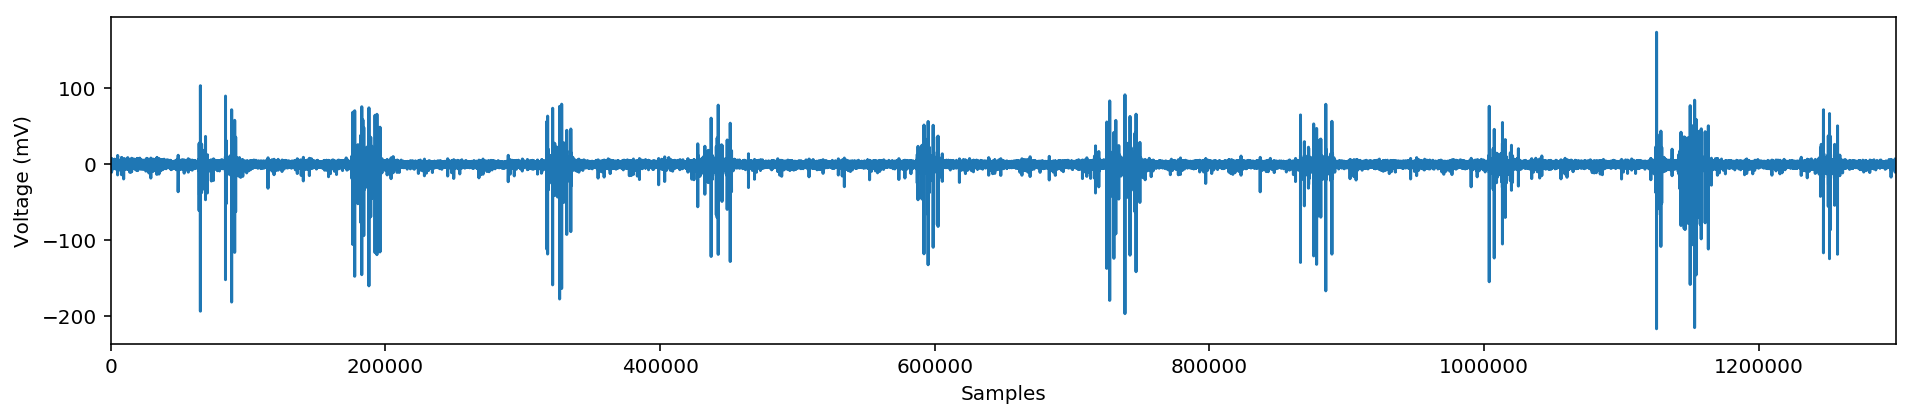

In [78]:
# Choose samples to work with (*not* timestamps)
signal = entire_recording[100000:1400000]

# Plot the subselected data
fig = plt.figure(figsize=(20,5))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.xlim([0,len(signal)])
plt.show()

# Spike sort!

To sort our spikes, we'll first determine the **standard deviation (std)** and **median absolute deviation** and use this to determine a recommended spike threshold.

In [11]:
noise_std = np.std(signal)
noise_mad = np.median(np.absolute(signal)) / 0.6745
recommended_threshold = -5 * noise_mad
print('Noise Estimate by Standard Deviation: {0:g} V'.format(noise_std))
print('Noise Estimate by MAD Estimator     : {0:g} V'.format(noise_mad))
print('Recommended Spike Threshold         : {0:g} V'.format(recommended_threshold))

Noise Estimate by Standard Deviation: 3.75948 V
Noise Estimate by MAD Estimator     : 1.41053 V
Recommended Spike Threshold         : -7.05263 V


## Determine a reasonable threshold & plot

You can set the spike threshold to be the same as the recommended threshold, or something slightly more conservative.

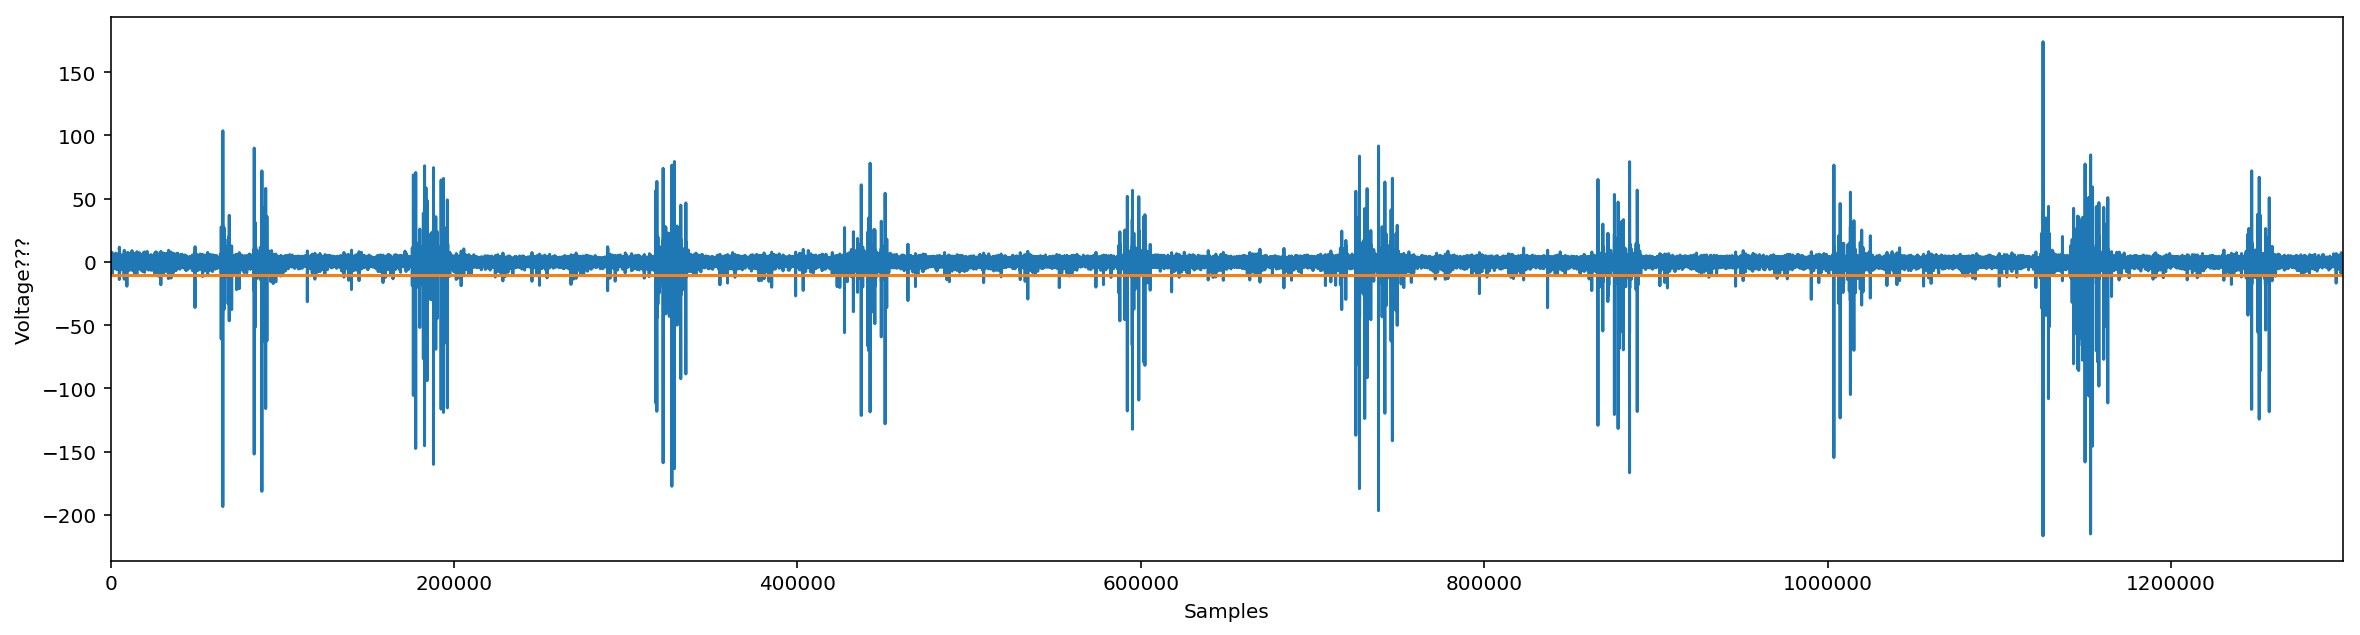

In [47]:
spike_threshold = -10 # Set your spike threshold here

fig = plt.figure(figsize=(20,5))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage???')
plt.plot([0, len(signal)], [spike_threshold, spike_threshold]) # add *1e6 to convert the threshold to µV for plotting
plt.xlim([0,len(signal)])
plt.show()

## Detect spikes and plot

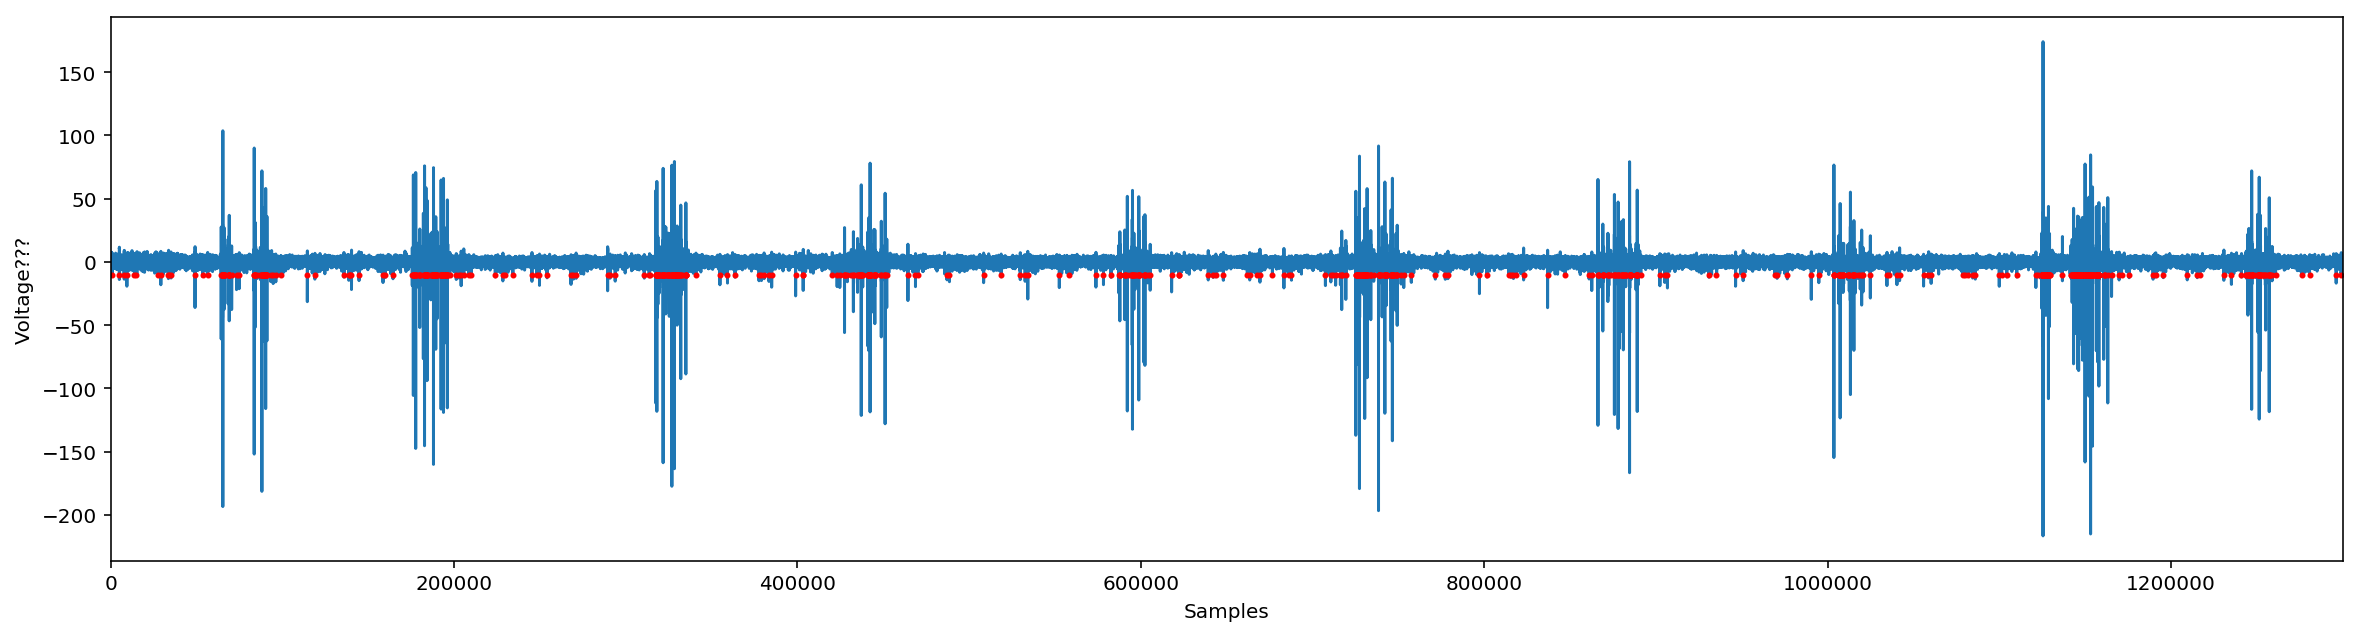

In [48]:
crossings = detect_threshold_crossings(signal, sampling_freq, spike_threshold, 0.003) # dead time of 3 ms
spks = align_to_minimum(signal, sampling_freq, crossings, 0.002) # search range 2 ms

fig = plt.figure(figsize=(20,5))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage???')
plt.plot(spks, [spike_threshold]*spks.shape[0], 'ro', ms=2)
plt.xlim([0,len(signal)])
plt.show()

## Extract Waveforms

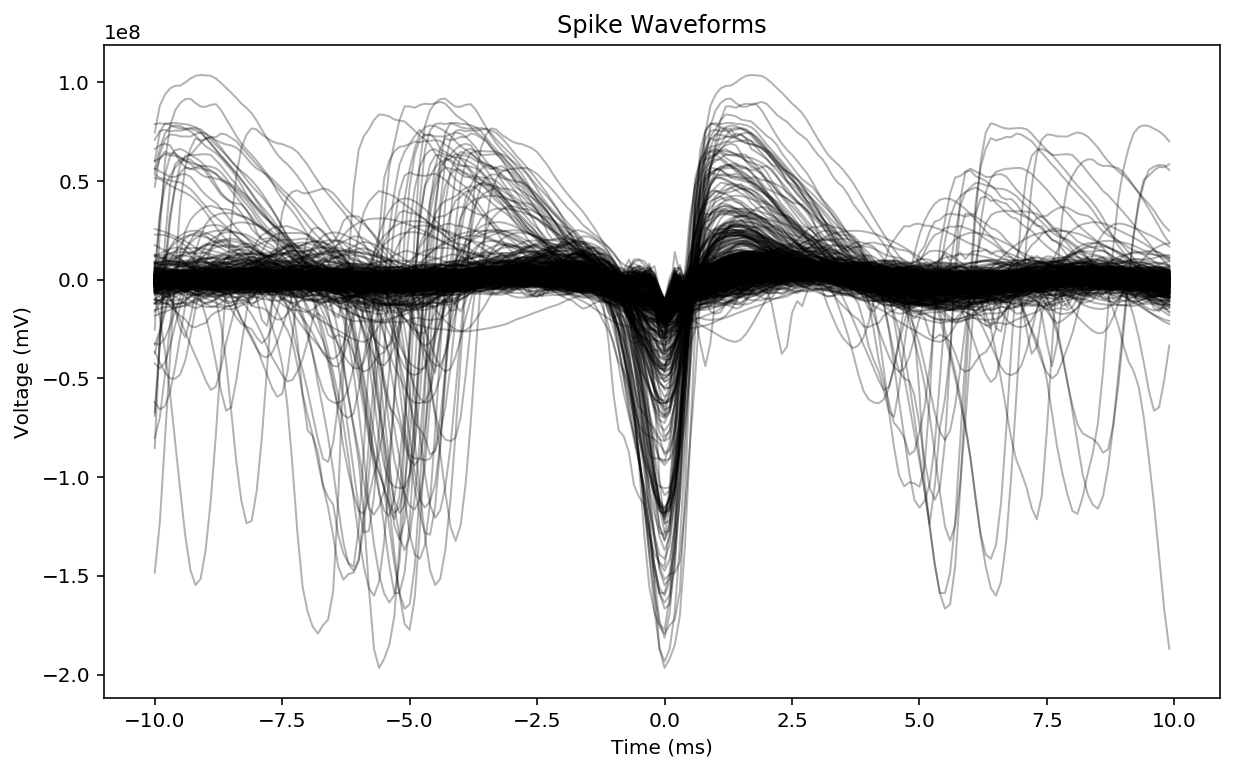

In [49]:
pre = 0.01 # 10 ms
post= 0.01 # 10 ms
waveforms = extract_waveforms(signal, sampling_freq, spks, pre, post)
plot_waveforms(waveforms, sampling_freq, pre, post, n=500)

## Run a PCA on extracted wavefroms

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_cutouts = scaler.fit_transform(waveforms)

pca = PCA()
pca.fit(scaled_cutouts)
#print(pca.explained_variance_ratio_)

pca.n_components = 3 # You could use 2 or 3, depending on the explained variance ratio...
transformed = pca.fit_transform(scaled_cutouts)

## Plot the results of our PCA

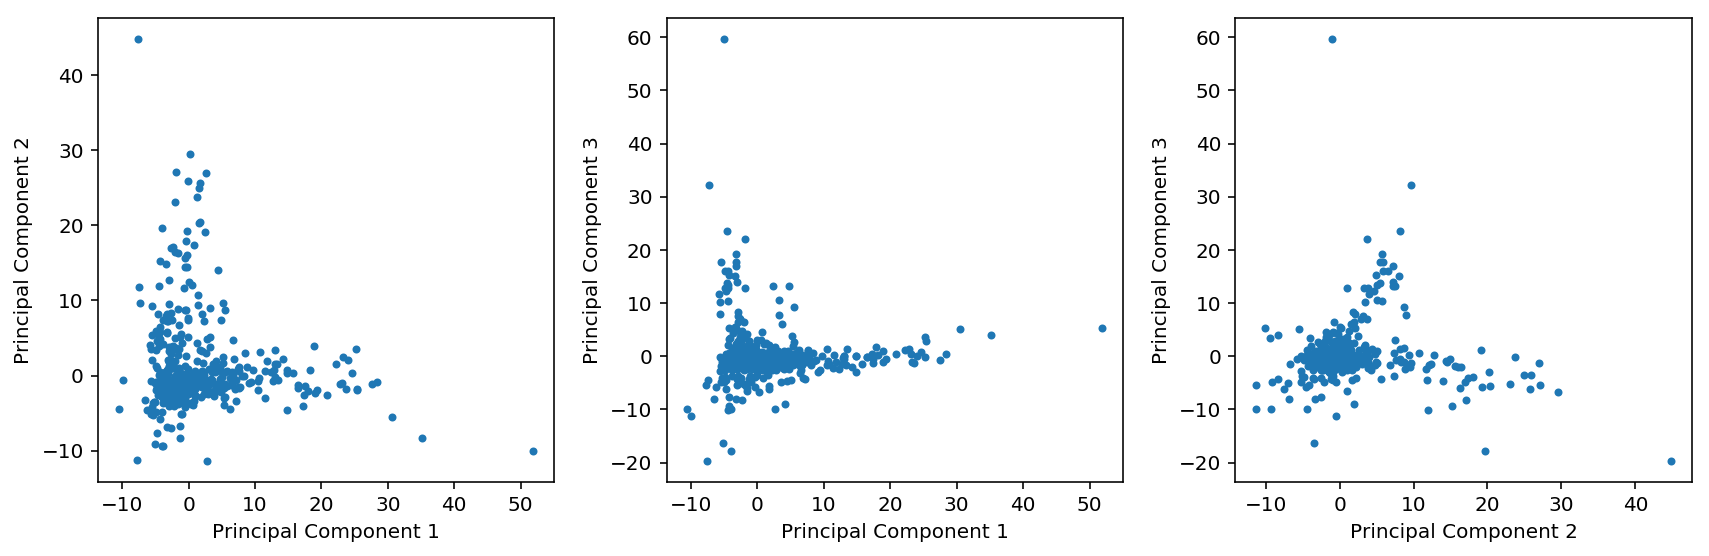

In [72]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].plot(transformed[:,0], transformed[:,1],'.')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

if pca.n_components >=3:

    ax[1].plot(transformed[:,0], transformed[:,2],'.')
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 3')

    ax[2].plot(transformed[:,1], transformed[:,2],'.')
    ax[2].set_xlabel('Principal Component 2')
    ax[2].set_ylabel('Principal Component 3')

plt.tight_layout()
plt.show()

## About this notebook
This notebook was largely inspired by [this tutorial](https://mcspydatatools.readthedocs.io/en/latest/McsPy-Tutorial_DataAnalysis.html).